In [1]:
#hide
#skip
%config Completer.use_jedi = False
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
# hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbverbose.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
#         assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virtual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
# default_exp data.gym

In [4]:
# export
# Python native modules
import os
from collections import deque
from copy import deepcopy
from time import sleep
from typing import *
# Third party libs
from fastcore.all import *
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.basics import *
from fastai.callback.all import *
from torch.utils.data import Dataset
from torch import nn
import torch
import gym
try:
    import pybulletgym
except ModuleNotFoundError as e:pass
import numpy as np
# Local modules
from fastrl.core import *
from fastrl.callback.core import *
from fastrl.data.block import *
from fastrl.agent import *

# Data Block Gym
> openai gym sources

## GymSource 
> The base iterable used for iterating through environments.

In [5]:
# # exports
# _loop=L(['event.after_create','Start Setup','event.initialize','End Setup',
#              'event.before_episodes',
#              'Start Episodes',
#                  'event.reset',
#                  'event.do_action',
#                  'event.do_step',
#                  'event.do_render',
#                  'event.before_history',
#                  'event.history',
#                  'event.after_history',
#              'End Episodes',
#              'event.after_episodes'
#              ])

# mk_class('source_events', **parse_events(_loop).map_dict(),
#          doc="All possible events as attributes to get tab-completion and typo-proofing")

# _all_=['source_events']

In [6]:
# # exports
# def return_data(o:dict): 
#     source,data=o['source'],o['history']
    
#     return {'source':source,'history':data}

# class Source(Loop):
#     _loop=_loop
#     _events=source_events
#     _default='source'    
#     end_event=parse_events(_loop)[-1]
    
#     @delegates(Loop)
#     def __init__(self,cbs=None,test_mode=False,**kwargs):
#         self.idx=0
#         self.data_fields='state,next_state,done,all_done,env_id,worker_id'\
#                            ',action,episode_id,accum_rewards,reward,step,image'.split(',')
#         self.ignore_fields=[]
#         self.test_field=torch.full((1,5),self.idx)
#         self.return_fn=return_data
#         self.loop_history_yield=False
#         store_attr(but='cbs',state=None,next_state=None,done=None,all_done=None,
#                    env_id=0,action=None,episode_id=0,accum_rewards=0,reward=0,step=0,
#                    skip_history_return=False)
#         super().__init__(cbs=cbs,**kwargs)
        
#     def after_create(self):
#         self('initialize')
#         return self
    
#     def _history(self):
#         self.loop_history_yield=False
#         self('history')
#         if self.test_mode: 
#             self.this=torch.full((1,5),self.idx)
#             if 'test_field' not in self.data_fields: self.data_fields.append('test_field')
#         return self.return_fn(dict(source=self,history=self.data()))['history']
    
#     def data(self)->BD: 
#         return BD({s:(ifnone(getattr(self,s,None),TensorBatch([[0]])) if self.test_mode else getattr(self,s))
#                 for s in self.data_fields if not in_(s,self.ignore_fields)})
        
#     def __iter__(self):
#         self('before_episodes')
#         while True:
#             self.idx+=1
#             self('reset')
#             self('do_action')
#             self('do_step')
#             if self.test_mode: self.test_field=torch.full((1,5),self.idx)
#             self('do_render')
#             self('before_history')
#             if not self.skip_history_return: yield self._history()
#             while self.loop_history_yield:   yield self._history()
#             self('after_history')

So the `Source` object does a simple loop that returns a dictionary. 
This is going to be similar to what the rest of fastrl will be expecting. 

In [7]:
# source=Source(test_mode=True)
# for x,_ in zip(iter(source),range(10)): print(x)

In [8]:
# Source().show_loop()

In [9]:
# export
class ReturnHistory(Transform):
    def encodes(self,o:dict):
        source,data=o['source'],o['history']
        history=sum(source.histories)
        if len(source.histories)==1 and sum(history['done'])>0:
            source.all_done=TensorBatch([[True]])
            history['all_done']=TensorBatch([[True]])
        source.histories.popleft()
        return {'source':source,'history':history}

In [10]:
import logging

In [11]:
_logger=logging.getLogger()
logging.basicConfig(format='[%(asctime)s.%(msecs)03d] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
                datefmt='%m-%d %H:%M:%S',level='INFO')

In [12]:
# export
class TstCallback(AgentCallback):
    def __init__(self,action_space=None,constant=None): store_attr()
    def before_noise(self):
        bs=self.experience['state'].shape[0]
        self.agent.action=Tensor([[self.constant] if self.constant is not None else 
                                   self.action_space.sample() 
                                   for _ in range(bs)])
        self.agent.experience=D(merge(self.experience,{'random_action':np.random.randint(0,3,(bs,1))}))

def np_type_cast(a,dtype): return a.astype(dtype)
        
class GymLoop(LoopCallback):
    _methods=source_events
    _default='source'
    def __init__(self,env_name:str,agent=None,mode=None,
                 steps_count:int=1,steps_delta:int=1,seed:int=None,
                 worker_id:int=0,dtype=None): 
        store_attr()
        
    def initialize(self):
        self.source.histories=deque(maxlen=self.steps_count)    
        self.source.return_fn=Pipeline([ReturnHistory])
        if self.mode!='rgb_array': self.source.ignore_fields.append('image')
        self.source.worker_id=get_worker_info()
        self.source.worker_id=TensorBatch(np.array([[getattr(self.worker_id,'id',0)]]))
        
        self.source.env=gym.make(self.env_name)
        if isinstance(self.env.action_space,gym.spaces.Discrete): 
            self.dtype=int
        elif isinstance(self.env.action_space,gym.spaces.Box):    
            if issubclass(self.env.action_space.dtype.type,(float,np.floating)): 
                self.dtype=partial(np_type_cast,dtype=float)
            if issubclass(self.env.action_space.dtype.type,(int,np.integer)): 
                self.dtype=partial(np_type_cast,dtype=int)
        else:
            self.dtype=float
        
        self.agent=ifnone(self.agent,Agent(cbs=TstCallback(action_space=self.env.action_space)))
        self.source.episode_id=TensorBatch(np.array([[0]]))
        self.source.done=TensorBatch(np.array([[True]]))
        self.source.all_done=TensorBatch(np.array([[True]]))
    
    def reset(self):
        if len(self.histories)==0 and sum(self.all_done)>=1:
            self.source.env_id=TensorBatch(np.array([[0]]))
            self.source.reward=TensorBatch(np.array([[0.0]]))
            self.source.episode_id+=1
            self.source.accum_rewards=TensorBatch(np.array([[0.0]]))
            self.source.step=TensorBatch(np.array([[0]]))
            self.source.env_id=TensorBatch(np.array([[0]]))
            self.source.done=TensorBatch(np.array([[False]]))
            self.source.all_done=TensorBatch(np.array([[False]]))
            self.source.env.seed(self.seed)
            self.source.state=TensorBatch(self.env.reset()).unsqueeze(0)
            if self.mode=='rgb_array': 
                self.source.image=TensorBatch(np.expand_dims(self.env.render(self.mode).copy(),0))

    def before_episodes(self): self('initialize')
        
    def do_step(self):
        action,experience=self.agent.do_action(**self.data())
        for k,v in experience.items(): 
            if v is not None: setattr(self.source,k,TensorBatch(v))
        self.source.action=TensorBatch(action)
        step_action=self.action.numpy()[0]
        next_state,reward,done,_=self.env.step(self.dtype(step_action))
        self.source.next_state=TensorBatch(next_state).unsqueeze(0)
        self.source.reward=TensorBatch(np.expand_dims(reward,(0,1)))
        self.source.accum_rewards+=reward
        self.source.done=TensorBatch(np.expand_dims(done,(0,1)))
        if self.mode=='rgb_array': 
            self.source.image=TensorBatch(np.expand_dims(self.env.render(self.mode).copy(),0))
        self.source.step+=1
    
    def before_history(self):
        self.source.skip_history_return=False
        self.histories.append(deepcopy(self.data()))

        if self.done.sum().item()<1:
            self.source.skip_history_return=len(self.histories)<self.steps_count or \
                                            int(self.step.item())%self.steps_delta!=0
    
    def history(self):
        if sum(self.done)>0 and len(self.histories)>1 and self.steps_count>1: 
            self.source.loop_history_yield=True
            
    def after_history(self):
        self.source.state=self.source.next_state
            
            
add_docs(GymLoop,"Handles iterating through single openai gym (and varients).",
         before_history="""Primarily appends `self.data()` to `self.histories` however it also...
         
         If the number of elements in `self.histories` is empty, or about to be empty, and
         `self.done==True` it sets the `self.all_done` field.
         
         If `self.done==True` also determine if we should skip returning a history.
         Mainly if we need to accumulate the histories first.
         """,
         initialize="Sets up most of the needed fields as well as the environment itself.",
         reset="Resets the env and fields if the histories have been emptied.",
         before_episodes="Call the initialization method again.",
         do_step="Get actions from the agent and take a step through the env.",
         history="If the environment is done, we want to loop through the histories and empty them.",
         after_history="Once everything is processed, we set the next state to the current state for the next loop.")

In [13]:
source=Source(
    cbs=GymLoop(env_name='HumanoidPyBulletEnv-v0')
)

WalkerBase::__init__


pybullet build time: Sep 20 2021 20:33:29
/home/fastrl_user/.local/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [14]:
source.show_loop()

 - after_create   : [GymLoop]
Start Setup
   - initialize     : [GymLoop]
End Setup
 - before_episodes: [GymLoop]
Start Episodes
   - reset          : [GymLoop]
   - do_action      : []
   - do_step        : [GymLoop]
   - do_render      : []
   - before_history : [GymLoop]
   - history        : [GymLoop]
   - after_history  : [GymLoop]
End Episodes
 - after_episodes : []


In [15]:
d=None 
source=Source(
    cbs=GymLoop(env_name='HumanoidPyBulletEnv-v0',steps_delta=4,steps_count=2)
)
for x,_ in zip(iter(source),range(50)): 
    if d is not None: d+=BD(x)
    else:             d=BD(x)
d.pandas(jupyter_nrows=300)

WalkerBase::__init__
WalkerBase::__init__


,state,next_state,done,all_done,env_id,worker_id,action,episode_id,accum_rewards,reward,step
0,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-5.246545,-0.834541,3
1,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-6.488873,-1.242329,4
2,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-9.831295,-0.925516,7
3,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-10.226918,-0.395623,8
4,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-12.232553,-0.718702,11
5,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-13.175136,-0.942583,12
6,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-19.003386,-2.261546,15
7,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-19.798702,-0.795317,16
8,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-25.215620,-1.492786,19
9,"torch.Size([93, 44])","torch.Size([93, 44])",False,False,0,0,"torch.Size([93, 17])",1,-26.060734,-0.845114,20


In [16]:
# export
class FirstLastTfm(Transform):
    def __init__(self,gamma):
        store_attr()
        super().__init__()
        
        
    def encodes(self,o):
#         print('encoding')
        source,history=o['source'],o['history']
#         print(source,history,o)
        element=history[0]
        if history.bs()!=1:
            remainder=history[1:]
            reward=element['reward']
            for e in reversed(remainder['reward']):
                reward*=self.gamma
                reward+=e
            element['reward']=reward
            element['next_state']=history[-1]['next_state']
            element['done']=history[-1]['done']
            
#         print(source,element)
        return {'source':source,'history':element}
    
class FirstLast(LoopCallback):
    _methods=source_events
    _default='source'
                
    def __init__(self,gamma=0.99): store_attr()
    def before_episodes(self): self('initialize')    
    def initialize(self):
        if isinstance(self.source.return_fn,Pipeline):
            self.source.return_fn.add(FirstLastTfm(self.gamma))
        else:
            self.source.return_fn=Pipeline([self.source.return_fn,FirstLastTfm(self.gamma)])

In [17]:
source.show_loop()

 - after_create   : [GymLoop]
Start Setup
   - initialize     : [GymLoop]
End Setup
 - before_episodes: [GymLoop]
Start Episodes
   - reset          : [GymLoop]
   - do_action      : []
   - do_step        : [GymLoop]
   - do_render      : []
   - before_history : [GymLoop]
   - history        : [GymLoop]
   - after_history  : [GymLoop]
End Episodes
 - after_episodes : []


In [18]:
d=None 
source=Source(
    cbs=[GymLoop(env_name='CartPole-v1',steps_delta=1,steps_count=1),FirstLast]
)
for x,_ in zip(iter(source),range(50)): 
    if d is not None: d+=BD(x)
    else:             d=BD(x)
d.pandas(jupyter_nrows=40)

,state,next_state,done,all_done,env_id,worker_id,action,episode_id,accum_rewards,reward,step
0,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,1.0,1,1.0,1.0,1
1,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,1.0,1,2.0,1.0,2
2,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,0.0,1,3.0,1.0,3
3,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,1.0,1,4.0,1.0,4
4,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,1.0,1,5.0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...
45,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,1.0,3,5.0,1.0,5
46,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,0.0,3,6.0,1.0,6
47,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,0.0,3,7.0,1.0,7
48,"torch.Size([50, 4])","torch.Size([50, 4])",False,False,0,0,1.0,3,8.0,1.0,8


In [19]:
d=None 
source=Source(
    cbs=[GymLoop(env_name='CartPole-v1',steps_delta=1,steps_count=4),FirstLast]
)
for x,_ in zip(iter(source),range(50)): 
    if d is not None: d+=BD(x)
    else:             d=BD(x)
d.pandas(mu=True,jupyter_nrows=300)[['state_mu','next_state_mu','done']]

,state_mu,next_state_mu,done
0,0.000255,0.053080,False
1,0.024760,0.031514,False
2,0.049732,0.010391,False
3,0.026832,0.037947,False
4,0.053080,0.066066,False
5,0.031514,0.046573,False
6,0.010391,0.027650,False
7,0.037947,0.008882,False
8,0.066066,0.038273,False
9,0.046573,0.067968,False


In [20]:
d=None 
source=Source(
    cbs=[GymLoop(env_name='HumanoidPyBulletEnv-v0',steps_delta=3),FirstLast]
)
for x,_ in zip(iter(source),range(50)): 
    if d is not None: d+=BD(x)
    else:             d=BD(x)
d.pandas(jupyter_nrows=300)

/home/fastrl_user/.local/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__


,state,next_state,done,all_done,env_id,worker_id,action,episode_id,accum_rewards,reward,step
0,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",1,-6.324941,-1.678391,3
1,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",1,-14.086597,-2.488842,6
2,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",1,-21.281883,-2.852470,9
3,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",1,-34.789528,-4.309023,12
4,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",1,-36.942932,-1.501129,15
5,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",1,-42.997581,-0.791601,18
6,"torch.Size([50, 44])","torch.Size([50, 44])",True,True,0,0,"torch.Size([50, 17])",1,-46.293945,-3.296362,19
7,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",2,-2.943001,-1.372911,3
8,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",2,-8.051725,-2.691116,6
9,"torch.Size([50, 44])","torch.Size([50, 44])",False,False,0,0,"torch.Size([50, 17])",2,-12.802928,-1.632365,9


In [21]:
# export
def show_source(src,iters=50):
    from IPython import display
    import PIL.Image
    
    for x,_ in zip(iter(src),range(iters)):
        for _img in x['image'].numpy():
            display.clear_output(wait=True)
            display.display(PIL.Image.fromarray(_img))
        


In [22]:
%matplotlib inline

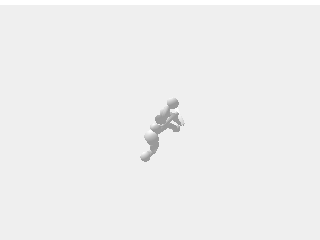

In [23]:
source=Source(
    cbs=[GymLoop(env_name='HumanoidPyBulletEnv-v0',mode='rgb_array',steps_delta=3),FirstLast]
)
show_source(source,50)

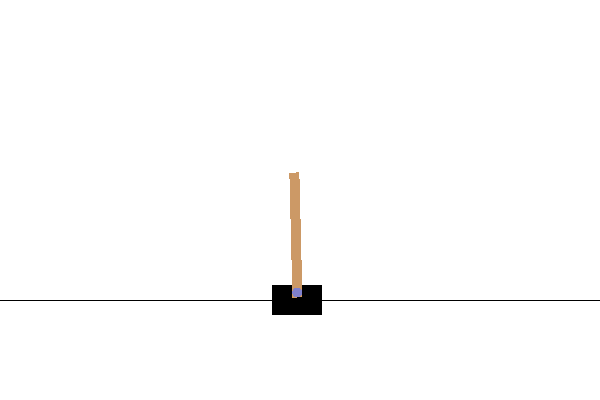

In [24]:
source=Source(
    cbs=[GymLoop(env_name='CartPole-v1',mode='rgb_array',steps_delta=3),FirstLast]
)
show_source(source,50)

### Metrics

In [25]:
# export
class Reward(Metric):
    order=30
    reward=None
    rolling_reward_n=100
    keep_rewards=False

    def reset(self):
        if self.reward is None: self.reward=deque(maxlen=self.rolling_reward_n)
            
    def accumulate(self,learn):
        xb=learn.xb[0]
        if xb['all_done'].sum()>0:
            final_rewards=to_detach(xb['accum_rewards'][xb['all_done']])
            for i in final_rewards.reshape(-1,).numpy().tolist(): self.reward.append(i)
                
    @property
    def value(self): return np.average(self.reward) if len(self.reward)>0 else 0

In [26]:
# export
class NEpisodes(Metric):
    order=30
    n_episodes=None

    def reset(self):
        if self.n_episodes is None: self.n_episodes=0
            
    def accumulate(self,learn):
        xb=learn.xb[0]
        if xb['all_done'].sum()>0:
            new_episodes=torch.unique(to_detach(xb['episode_id'][xb['all_done']]))
            self.n_episodes+=len(new_episodes)
                
                
    @property
    def value(self): return self.n_episodes

In [27]:
# export 
def fake_gym_learner(source,n=1000,bs=1,num_workers=0):
    from torch.nn import Linear

    class FakeModel(Module):
        def __init__(self):  self.fc=Linear(5,5)
        def forward(self,x): return x

    block=SourceDataBlock()
    dls=block.dataloaders([source],n=n,bs=bs,num_workers=num_workers,verbose=False)
    return Learner(dls,FakeModel(),metrics=[Reward,NEpisodes],loss_func=lambda o: 0.5)

In [28]:
source=Source(cbs=[GymLoop(env_name='CartPole-v1'),FirstLast])
learn=fake_gym_learner(source,bs=64)
learn.fit(4)

Could not do one pass in your dataloader, there is something wrong in it


argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=


## Export

In [29]:
# hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.export import *
    from nbdev.export2html import *
    from nbverbose.cli import *
    make_readme()
    notebook2script()
    notebook2html()

converting /home/fastrl_user/fastrl/nbs/index.ipynb to README.md
Converted 00_core.ipynb.
Converted 00_nbdev_extension.ipynb.
Converted 03_callback.core.ipynb.
Converted 04_agent.ipynb.
Converted 05_data.test_async.ipynb.
Converted 05a_data.block.ipynb.
Converted 05b_data.gym.ipynb.
Converted 06a_memory.experience_replay.ipynb.
Converted 10a_agents.dqn.core.ipynb.
Converted 10b_agents.dqn.targets.ipynb.
Converted 10c_agents.dqn.double.ipynb.
Converted 10d_agents.dqn.dueling.ipynb.
Converted 10e_agents.dqn.categorical.ipynb.
Converted 11a_agents.policy_gradient.ppo.ipynb.
Converted 20_test_utils.ipynb.
Converted index.ipynb.
Converted nbdev_template.ipynb.
converting: /home/fastrl_user/fastrl/nbs/05b_data.gym.ipynb
